# 3x3 Sensor Array for Water Sensor, Multi file
Author: Jonathan

# Standard step test

## Load

### Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.dates as mdates
from datetime import datetime, timedelta


print(sys.executable)

%matplotlib ipympl

color_array = [
    (0.121, 0.466, 0.705, 1.0),  # Muted blue
    (1.000, 0.498, 0.055, 1.0),  # Muted orange
    (0.172, 0.627, 0.172, 1.0),  # Muted green
    (0.839, 0.153, 0.157, 1.0),  # Muted red
    (0.580, 0.404, 0.741, 1.0),  # Muted purple
    (0.549, 0.337, 0.294, 1.0),  # Muted brown
    (0.890, 0.466, 0.760, 1.0),  # Muted pink
    (0.498, 0.498, 0.498, 1.0),  # Muted gray
    (0.737, 0.741, 0.133, 1.0),  # Muted yellow-green
]


/usr/bin/python3


In [2]:
!ls "/tf/data"

ASM_module  cecilie  ec  karena  lawance  odorMaster  waterSensor  wendy


### Class

In [399]:
class myWaterTest:
  def __init__(self, testingTime, cumTimeOffset=0, liquLabel = 'DI Water', liquConc = '0uL/100mL', testingSequence=[]):
    self.testingTime = testingTime
    self.cumTimeOffset = cumTimeOffset#-10
    self.liquLabel = liquLabel
    self.liquConc = liquConc
    self.csvFile = '/tf/data/waterSensor/aryData/sensor_'+testingTime+'.csv'
    self.sequenceCsvFile = '/tf/data/waterSensor/aryData/pump_sequence_'+testingTime+'.csv'
      
    #Sensor data
    colnames = ['time']+[f'px{i}' for i in range(9)]
    self.df=pd.read_csv(self.csvFile, names=colnames, header=None, skipfooter=1, engine='python')
    
    self.df['datetime'] = pd.to_datetime(self.df['time'], format='%Y-%m-%dT%H:%M:%S%z').dt.tz_localize(None)
    self.df = self.df.set_index(['datetime'])
    self.df = self.df.drop('time', axis=1)
    self.df.asfreq('s', method='ffill')

    #Control data
    self.seq_df=pd.read_csv(self.sequenceCsvFile, usecols=['Time(s)']+[f"Pump {i+1} (rpm)" for i in range(6)])
    seq_cycle = int(pd.read_csv(self.sequenceCsvFile)['Cycle'][0])
    self.seq_df = pd.concat([self.seq_df]*seq_cycle)
    self.seq_df['cumTime'] = self.seq_df['Time(s)'].cumsum(axis = 0)
    self.seq_df = self.seq_df.rename(columns=dict(zip([f"Pump {i+1} (rpm)" for i in range(6)], [f"Pump{i+1}" for i in range(6)])))
    
    self.seq_df = pd.DataFrame(
        data=self.seq_df.values.repeat(2, axis=0),  # Repeat each row twice
        columns=self.seq_df.columns                # Keep the column names
    )
    self.seq_df['cumTime'] = self.seq_df['cumTime'].shift(1).fillna(0)
    self.seq_df.loc[self.seq_df.index[1::2], 'cumTime'] = self.seq_df.loc[self.seq_df.index[1::2], 'cumTime'] - 1
    
    self.seq_df["timestamp"] = self.seq_df["cumTime"].apply(lambda x: self.df.index[0] + timedelta(seconds=x) if x >= 0 else None)
    self.seq_df.set_index("timestamp", inplace=True)
    
    #Set keyframe
    flowRatePt = 20
    self.keyTime = self.seq_df[(self.seq_df.Pump2>0)|(self.seq_df.Pump3>0)|(self.seq_df.Pump4>0)|(self.seq_df.Pump5>0)].index #(seq_df.Pump1==20)|
    self.keyTime = self.keyTime[1::2]
    self.keyTime = self.keyTime[1::2]
    # print(keyTime)

    flowRatePt = 100
    # self.keyTimeBaseline = self.seq_df[(self.seq_df.Pump2==flowRatePt)|(self.seq_df.Pump3==flowRatePt)|(self.seq_df.Pump4==flowRatePt)|(self.seq_df.Pump5==flowRatePt)].index
    # self.keyTimeBaseline = self.seq_df[(self.seq_df.Pump1==100)].index
    # self.keyTimeBaseline = self.keyTimeBaseline[::2]
    # print(keyTimeBaseline)

    self.testingSequence = testingSequence*seq_cycle #uL

### File

In [400]:
myTest = []

testingSequence = [10, 30, 60, 100] #uL:1L
myTest.append(myWaterTest('20250603_125215', liquLabel = 'Acetone', liquConc = '10uL/100mL', testingSequence=testingSequence))
myTest.append(myWaterTest('20250603_172217', liquLabel = 'Benzene', liquConc = '10uL/100mL', testingSequence=testingSequence))
myTest.append(myWaterTest('20250603_202421', liquLabel = 'Toluene', liquConc = '10uL/100mL', testingSequence=testingSequence))
myTest.append(myWaterTest('20250603_232616', liquLabel = 'Formaldehyde', liquConc = '10uL/100mL', testingSequence=testingSequence))

In [401]:
myTest[0].testingSequence

[10, 30, 60, 100, 10, 30, 60, 100]

In [256]:
pltMax = []
pltMin = []

for myTestItem in myTest:
    pltMax.append(myTestItem.df.max().max())
    pltMin.append(myTestItem.df.max().max())
    
pltMax = np.max(pltMax)    
pltMin = np.min(pltMin)
print(pltMax, pltMin)

3084 2884


## Plot

### All plot

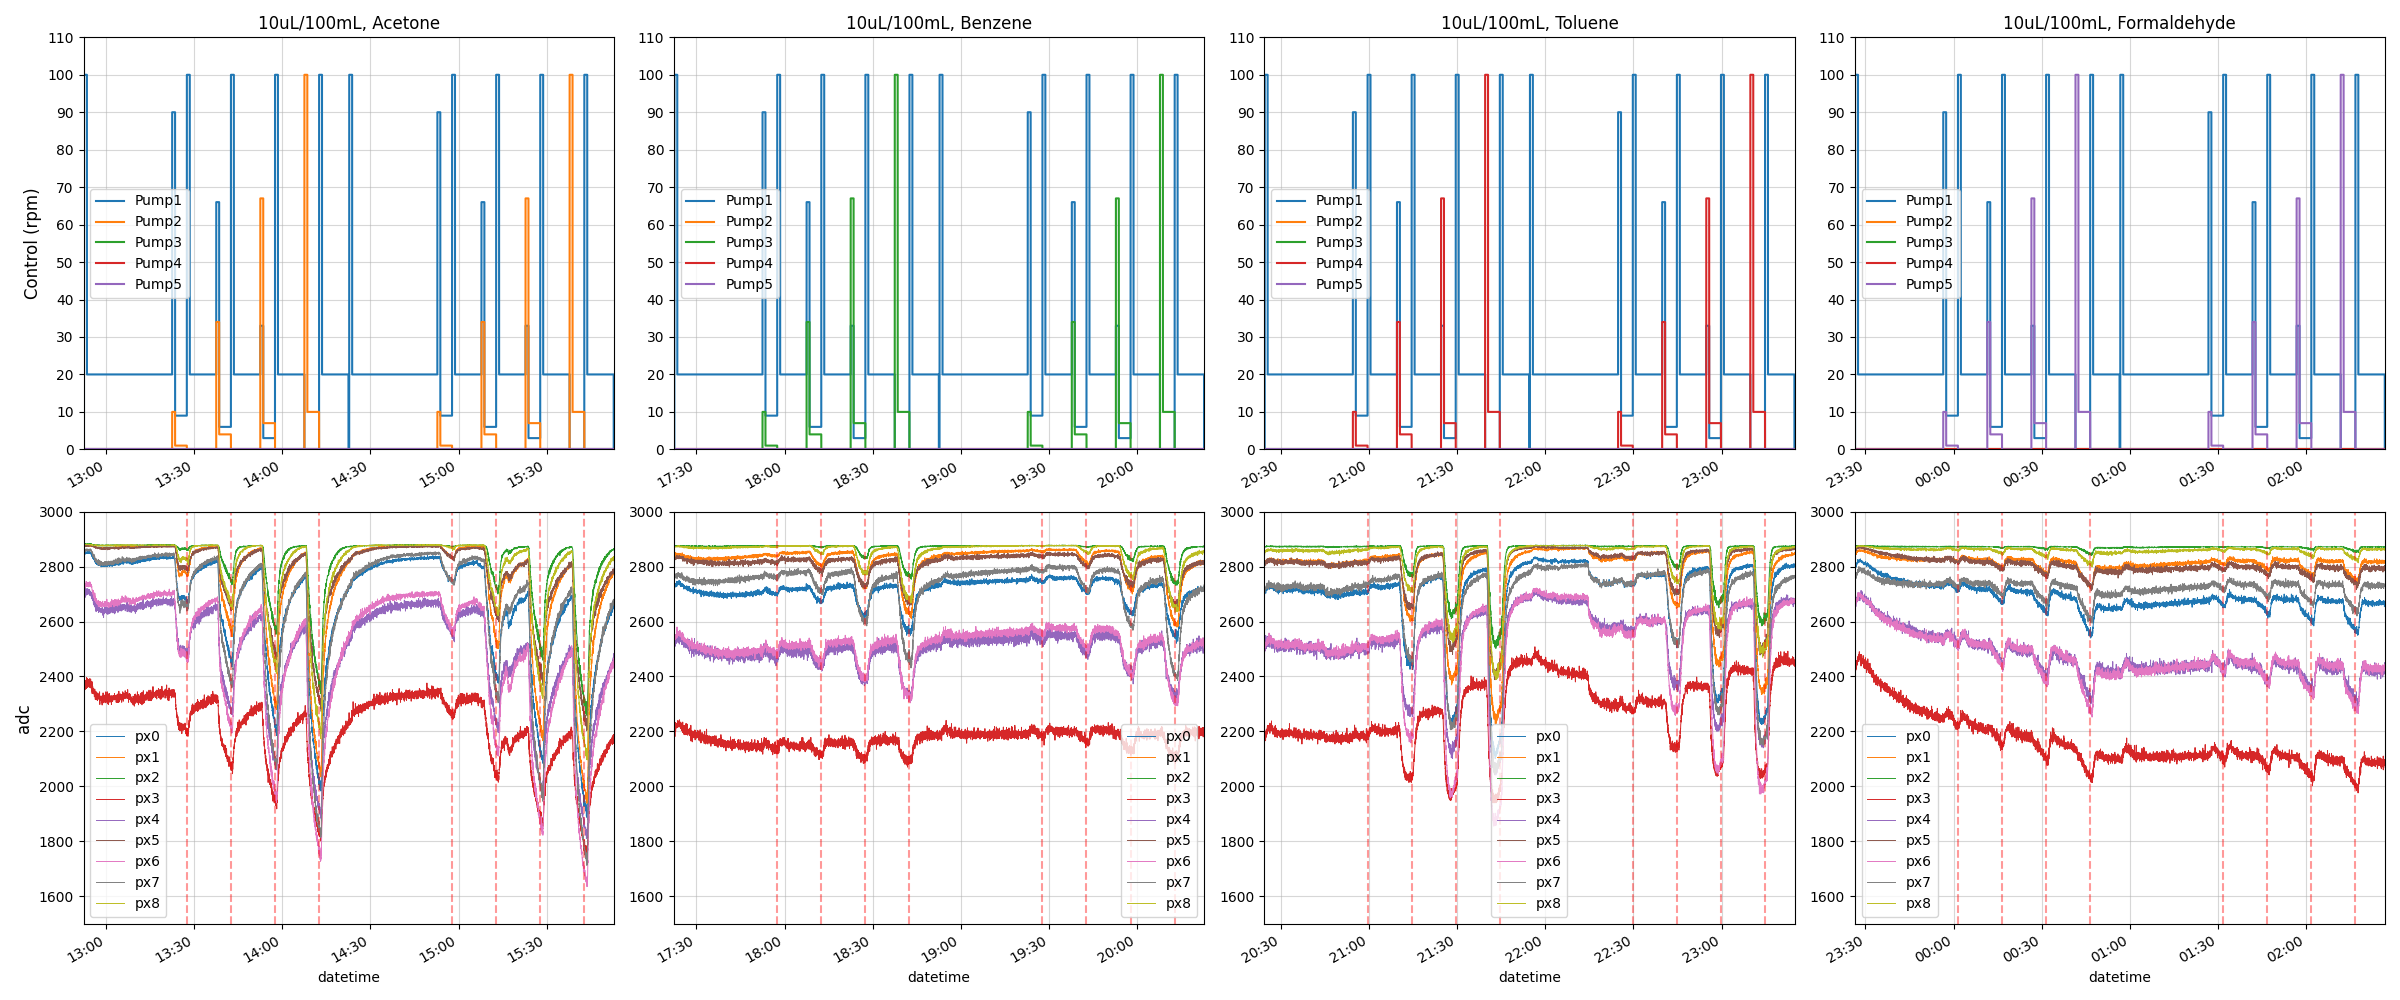

In [263]:
thisTestId = 1
    
plt.close('all')
fig, ax = plt.subplots(nrows=2,ncols=len(myTest), figsize=(24,10))

for thisTestId in range(len(myTest)):
    thisAx=ax[0, thisTestId]
    for i in range(5):
        myTest[thisTestId].seq_df.plot(ax=thisAx, y=f'Pump{i+1}', lw=1.5, alpha=1)
    thisAx.set_title(f'{myTest[thisTestId].liquConc}, {myTest[thisTestId].liquLabel}')
    if thisTestId == 0:
        thisAx.set_ylabel("Control (rpm)",fontsize=12)
    
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    thisAx.yaxis.set_major_locator(MultipleLocator(10))
    thisAx.xaxis.set_major_locator(MultipleLocator(6/(12*24)))
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlabel('')
    thisAx.set_ylim([0, 110])
    thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    thisAx=ax[1, thisTestId]
    for i in range(9):
        myTest[thisTestId].df.plot(ax=thisAx, y=f'px{i}', lw=0.7, color = color_array[i]) #, alpha = (i+1)/9, color='black'
    
    for time in myTest[thisTestId].keyTime:
        thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.4)
        
    # for time in myTest[thisTestId].keyTimeBaseline:
    #     thisAx.axvline(x=time, color='blue', linestyle='--', alpha=0.2)
    if thisTestId == 0:
        thisAx.set_ylabel("adc",fontsize=12)
    thisAx.grid(which='minor', alpha=0.3)
    thisAx.grid(which='major', alpha=0.5)
    thisAx.yaxis.set_major_locator(MultipleLocator(200))
    thisAx.xaxis.set_major_locator(MultipleLocator(6/(12*24)))
    # thisAx.set_ylim([myTest[thisTestId].df[[f'px{i}' for i in range(9)]].min().min(), myTest[thisTestId].df[[f'px{i}' for i in range(9)]].max().max()])
    thisAx.set_ylim([1500, 3000])
    thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
    # thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()



### Single plot

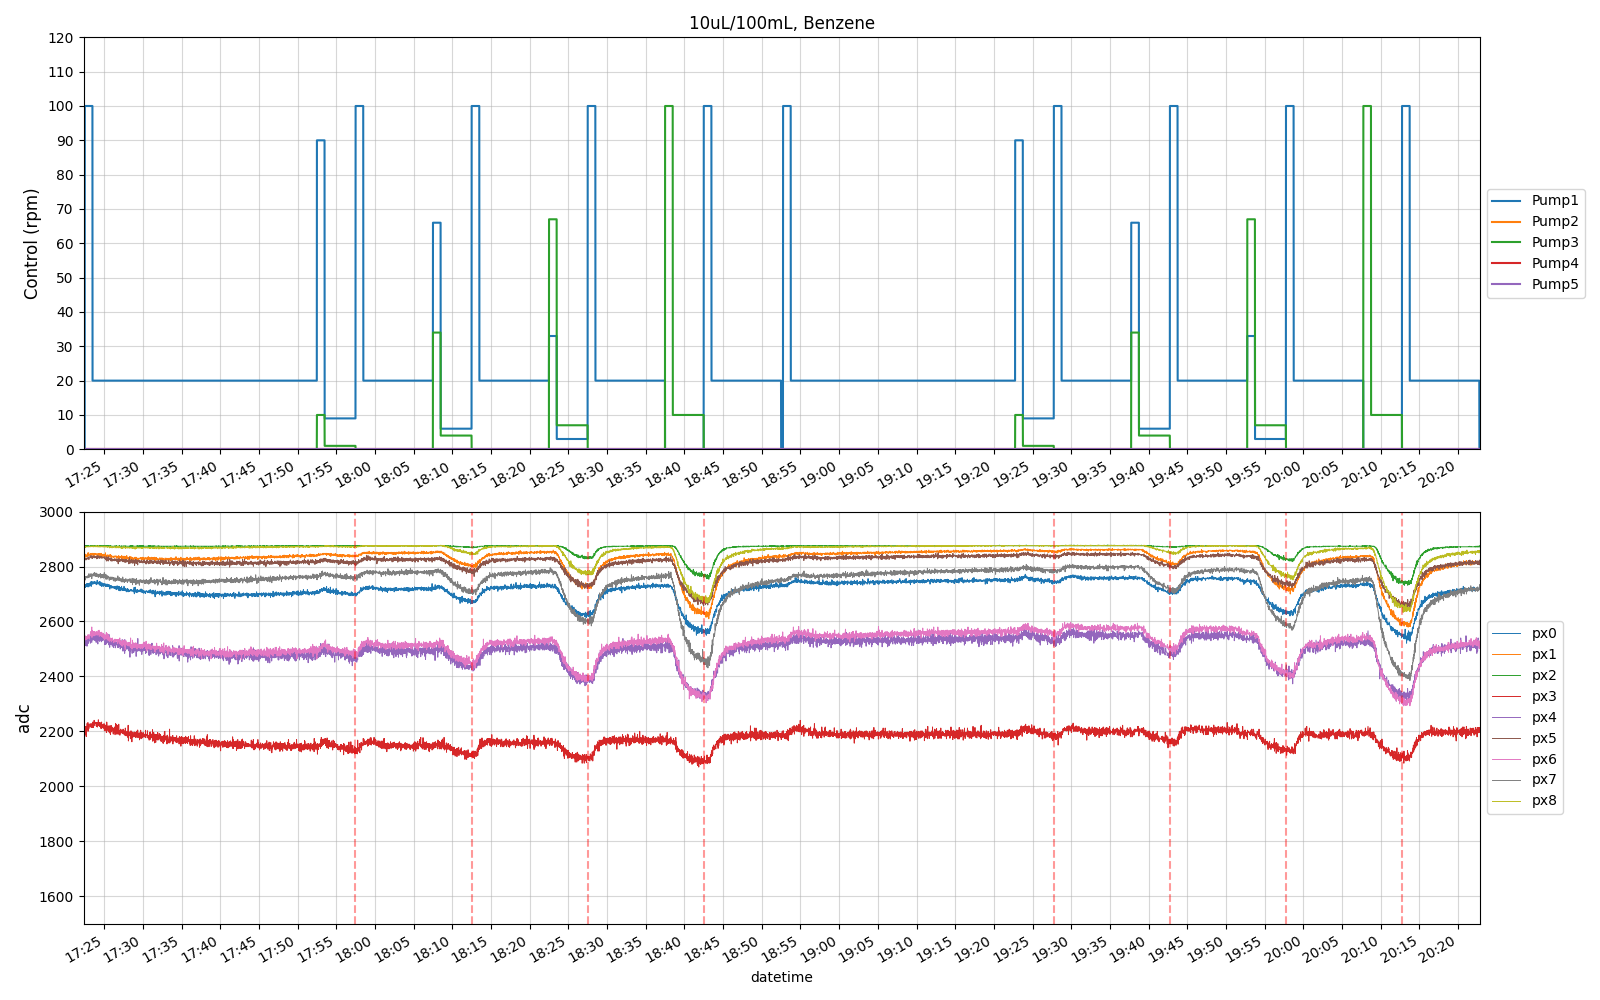

In [264]:
thisTestId = 1

plt.close('all')
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(16,10))

thisAx=ax[0]
for i in range(5):
    myTest[thisTestId].seq_df.plot(ax=thisAx, y=f'Pump{i+1}', lw=1.5, alpha=1)
thisAx.set_title(f'{myTest[thisTestId].liquConc}, {myTest[thisTestId].liquLabel}')

thisAx.set_ylabel("Control (rpm)",fontsize=12)

thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.yaxis.set_major_locator(MultipleLocator(10))
thisAx.xaxis.set_major_locator(MultipleLocator(1/(12*24)))
thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
thisAx.set_xlabel('')
thisAx.set_ylim([0, 120])
thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

thisAx=ax[1]
for i in range(9):
    myTest[thisTestId].df.plot(ax=thisAx, y=f'px{i}', lw=0.7, color = color_array[i]) #, alpha = (i+1)/9, color='black'

for time in myTest[thisTestId].keyTime:
    thisAx.axvline(x=time, color='red', linestyle='--', alpha=0.4)
    
# for time in myTest[thisTestId].keyTimeBaseline:
#     thisAx.axvline(x=time, color='blue', linestyle='--', alpha=0.2)
    
thisAx.set_ylabel("adc",fontsize=12)
thisAx.grid(which='minor', alpha=0.3)
thisAx.grid(which='major', alpha=0.5)
thisAx.yaxis.set_major_locator(MultipleLocator(200))
thisAx.xaxis.set_major_locator(MultipleLocator(1/(12*24)))
# thisAx.set_ylim([myTest[thisTestId].df[[f'px{i}' for i in range(9)]].min().min(), myTest[thisTestId].df[[f'px{i}' for i in range(9)]].max().max()])
thisAx.set_ylim([1500, 3000])
thisAx.xaxis.set_major_formatter(DateFormatter('%H:%M'))
thisAx.set_xlim(myTest[thisTestId].seq_df.index.min(), myTest[thisTestId].seq_df.index.max())
thisAx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()



### Save plot to svg

In [59]:
#f'exportSvg/raw_{myTest[thisTestId].testingTime}_{myTest[thisTestId].liquLabel}.svg'
plt.savefig(f'exportSvg/raw_{myTest[thisTestId].testingTime}_{myTest[thisTestId].liquLabel}.svg', bbox_inches='tight', pad_inches = 0)

'exportSvg/raw_20250603_125215_Acetone.svg'

## Calibration

### Baseline correction

In [266]:
myTest[0].df

,px0,px1,px2,px3,px4,px5,px6,px7,px8
datetime,,,,,,,,,
2025-06-03 12:52:21,2846,2876,2882,2378,2694,2876,2722,2860,2880
2025-06-03 12:52:24,2849,2874,2880,2372,2692,2874,2722,2857,2880
2025-06-03 12:52:27,2844,2876,2882,2369,2687,2876,2728,2856,2880
2025-06-03 12:52:28,2848,2876,2880,2382,2700,2876,2721,2857,2880
2025-06-03 12:52:30,2844,2874,2882,2360,2696,2876,2724,2857,2880
...,...,...,...,...,...,...,...,...,...
2025-06-03 15:56:59,2678,2810,2870,2161,2457,2802,2484,2712,2853
2025-06-03 15:57:00,2684,2805,2872,2162,2500,2810,2486,2708,2852
2025-06-03 15:57:01,2685,2805,2871,2146,2476,2812,2484,2706,2854


### Get Keyframe

In [411]:
import pandas as pd

# Initialize an empty list to store subframes
all_subframes = []

# Loop over all myTest objects
for thisTestId, test in enumerate(myTest):
    # Sort the DataFrame by its index
    df = test.df.sort_index()
    
    # Create a DataFrame from keyTime
    key_time_df = pd.DataFrame({'timestamp': test.keyTime})
    
    # Perform an asof merge to get the nearest matches
    subframe = pd.merge_asof(key_time_df, df, left_on='timestamp', right_index=True)
    
    # Add a column to indicate the test ID
    subframe['yy'] = thisTestId
    #print(test.testingSequence)
    subframe['conc'] = test.testingSequence
    # Append the processed subframe to the list
    all_subframes.append(subframe)

# Concatenate all subframes into a single DataFrame
key_df = pd.concat(all_subframes, ignore_index=True)
key_df

,timestamp,px0,px1,px2,px3,px4,px5,px6,px7,px8,yy,conc
0,2025-06-03 13:27:30,2678,2774,2864,2184,2481,2786,2468,2638,2824,0,10
1,2025-06-03 13:42:30,2472,2569,2748,2067,2274,2652,2221,2392,2668,0,30
2,2025-06-03 13:57:30,2218,2314,2584,1943,2092,2498,1977,2094,2468,0,60
3,2025-06-03 14:12:30,2007,2081,2386,1823,1926,2328,1760,1855,2236,0,100
4,2025-06-03 14:57:45,2742,2834,2874,2254,2562,2837,2572,2749,2868,0,10
5,2025-06-03 15:12:45,2410,2528,2724,2029,2234,2638,2154,2346,2652,0,30
6,2025-06-03 15:27:45,2130,2214,2509,1884,2018,2414,1862,2005,2372,0,60
7,2025-06-03 15:42:45,1938,1992,2310,1798,1870,2258,1698,1793,2166,0,100
8,2025-06-03 17:57:29,2700,2838,2874,2138,2455,2824,2478,2758,2872,1,10
9,2025-06-03 18:12:29,2670,2802,2870,2116,2434,2788,2440,2704,2850,1,30


#### plot frame

In [290]:
key_df.iloc[0][[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64)

array([2678, 2774, 2864, 2184, 2481, 2786, 2468, 2638, 2824])

In [292]:
gasMat = np.reshape(key_df.iloc[0][[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64), (-1,3)).astype(int)
gasMat

array([[2678, 2774, 2864],
       [2184, 2481, 2786],
       [2468, 2638, 2824]])

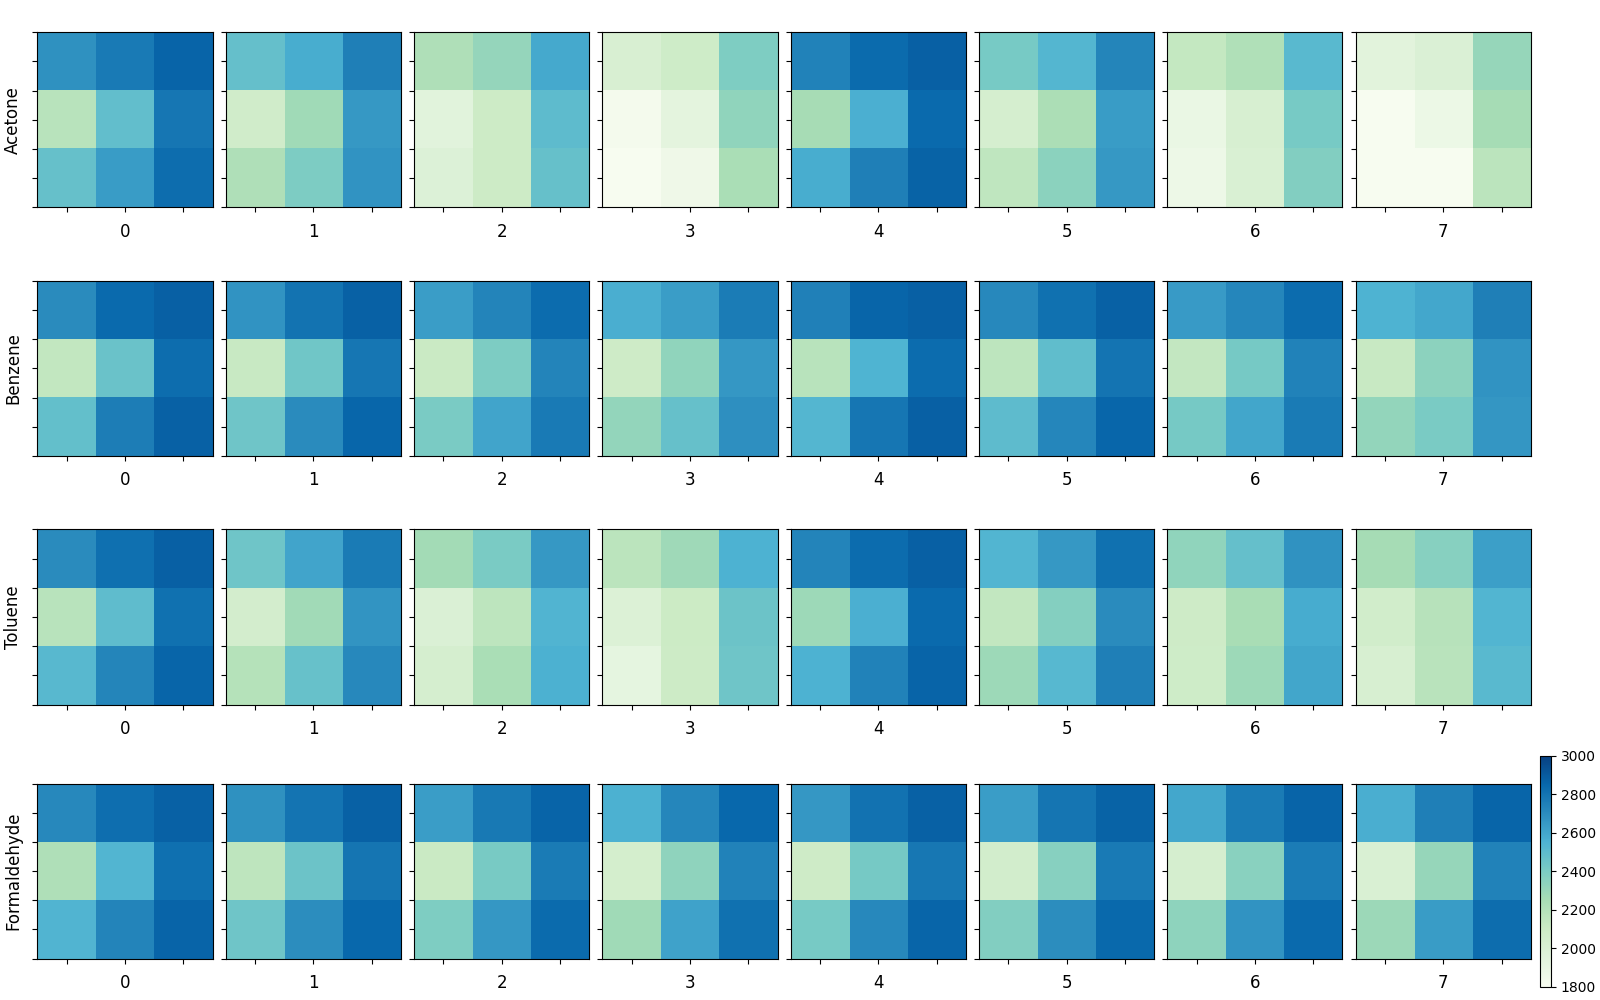

In [382]:
plt.close('all')
fig, ax = plt.subplots(
    ncols=key_df['yy'].value_counts()[0],
    nrows=key_df['yy'].max() + 1,
    figsize=(16, 10),
    constrained_layout=True
)

# Iterate through rows of the DataFrame and create subplots
for index, row in key_df.iterrows():
    thisAx = ax[row['yy'], index % 8]
    gasMat = np.reshape(
        row[[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64),
        (-1, 3)
    ).astype(int)
    im = thisAx.imshow(gasMat, cmap='GnBu', vmin=1800, vmax=3000, interpolation='nearest')

    if index % 8 == 0:
        thisAx.set_ylabel(myTest[row['yy']].liquLabel, fontsize=12)
    thisAx.set_xlabel(index % 8, fontsize=12)

# Remove tick labels from all subplots
for rowAx in ax:
    for thisAx in rowAx:
        thisAx.set_yticklabels([])
        thisAx.set_xticklabels([])

# fig.subplots_adjust(right=0.88) 

# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # Position for the color bar
# fig.colorbar(im, cax=cbar_ax)  # Use the last `imshow` reference for the colorbar
fig.colorbar(im) 

/tmp/ipykernel_1440/823436765.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


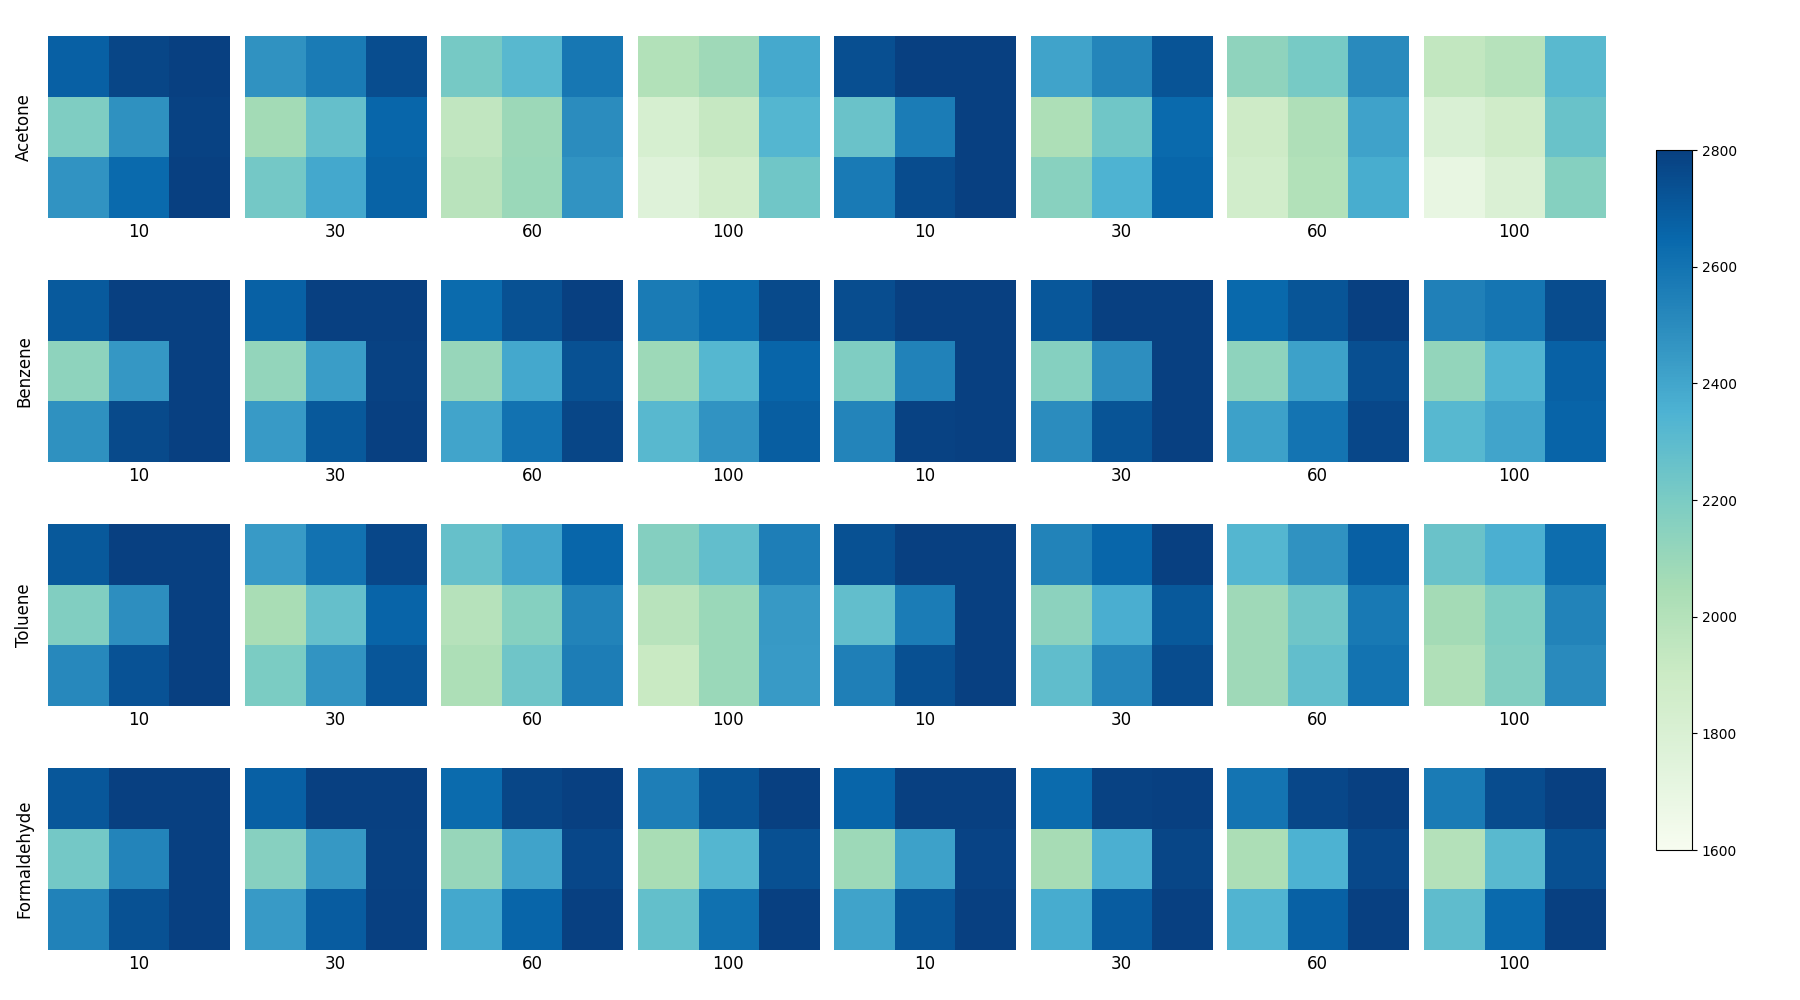

In [414]:
plt.close('all')

fig, ax = plt.subplots(
    ncols=key_df['yy'].value_counts()[0],  # 8 for images + 1 for the colorbar
    nrows=key_df['yy'].max() + 1,  # Based on the unique 'yy' values
    figsize=(18, 10)  # Increase width slightly for colorbar space
)

# Iterate through rows of the DataFrame and create subplots
for index, row in key_df.iterrows():
    thisAx = ax[row['yy'], index % 8]  # Use the first 8 columns for images
    gasMat = np.reshape(
        row[[f'px{i}' for i in range(0, 9)]].to_numpy().astype(np.int64),
        (-1, 3)
    ).astype(int)
    im = thisAx.imshow(gasMat, cmap='GnBu', vmin=1600, vmax=2800, interpolation='nearest')

    if index % 8 == 0:
        thisAx.set_ylabel(myTest[row['yy']].liquLabel, fontsize=12)
    thisAx.set_xlabel(row['conc'], fontsize=12)

# Remove tick labels from all subplots
for rowAx in ax:
    for thisAx in rowAx:  # Skip the last column (colorbar column)
        for side in ['top','right','bottom','left']:
            thisAx.spines[side].set_visible(False)
        thisAx.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
        thisAx.set_yticklabels([])
        thisAx.set_xticklabels([])

# Use the entire 9th column for a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define the position of the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='vertical')  # Add the single colorbar
# cbar_ax.set_ylabel("ADC", fontsize=12, labelpad=10)  # Label for the colorbar
cbar_ax.tick_params(labelsize=10)  # Adjust tick size

# Adjust layout
fig.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

In [379]:
myTest[0].seq_df

,Time(s),Pump1,Pump2,Pump3,Pump4,Pump5,Pump6,cumTime
timestamp,,,,,,,,
2025-06-03 12:52:21,5,0,0,0,0,0,0,0.0
2025-06-03 12:52:25,5,0,0,0,0,0,0,4.0
2025-06-03 12:52:26,5,0,0,0,0,0,-150,5.0
2025-06-03 12:52:30,5,0,0,0,0,0,-150,9.0
2025-06-03 12:52:31,60,100,0,0,0,0,-150,10.0
...,...,...,...,...,...,...,...,...
2025-06-03 15:43:45,60,100,0,0,0,0,-150,10284.0
2025-06-03 15:43:46,540,20,0,0,0,0,-150,10285.0
2025-06-03 15:52:45,540,20,0,0,0,0,-150,10824.0


#### PCA

In [209]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [219]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(key_df[[f'px{i}' for i in range(1, 9)]])

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_pca = pca.fit_transform(X_scaled)

# label_mapping = {label: idx for idx, label in enumerate(y.unique())}
# y_encoded = y.map(label_mapping)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
# pca_df['label'] = key_df[[f'Pump{i}' for i in range(1, 6)]]*3
# Split the data into training and testing sets
pca_df['yy'] = key_df['yy']
pca_df

,PC1,PC2,yy
0,2.066104,0.404945,0
1,-0.587030,0.052395,0
2,-3.592175,-0.053190,0
3,-6.580792,-0.044180,0
4,3.056857,0.819056,0
5,-1.124153,-0.164245,0
6,-4.914039,-0.145196,0
7,-7.554021,0.085884,0
8,2.345978,-0.248278,1
9,1.920424,-0.312253,1


In [229]:
color_dict = {
    0: color_array[1],
    1: color_array[2],
    2: color_array[3],
    3: color_array[4],
    4: color_array[5],
    5: color_array[6],
}


KeyError: 'PC3'

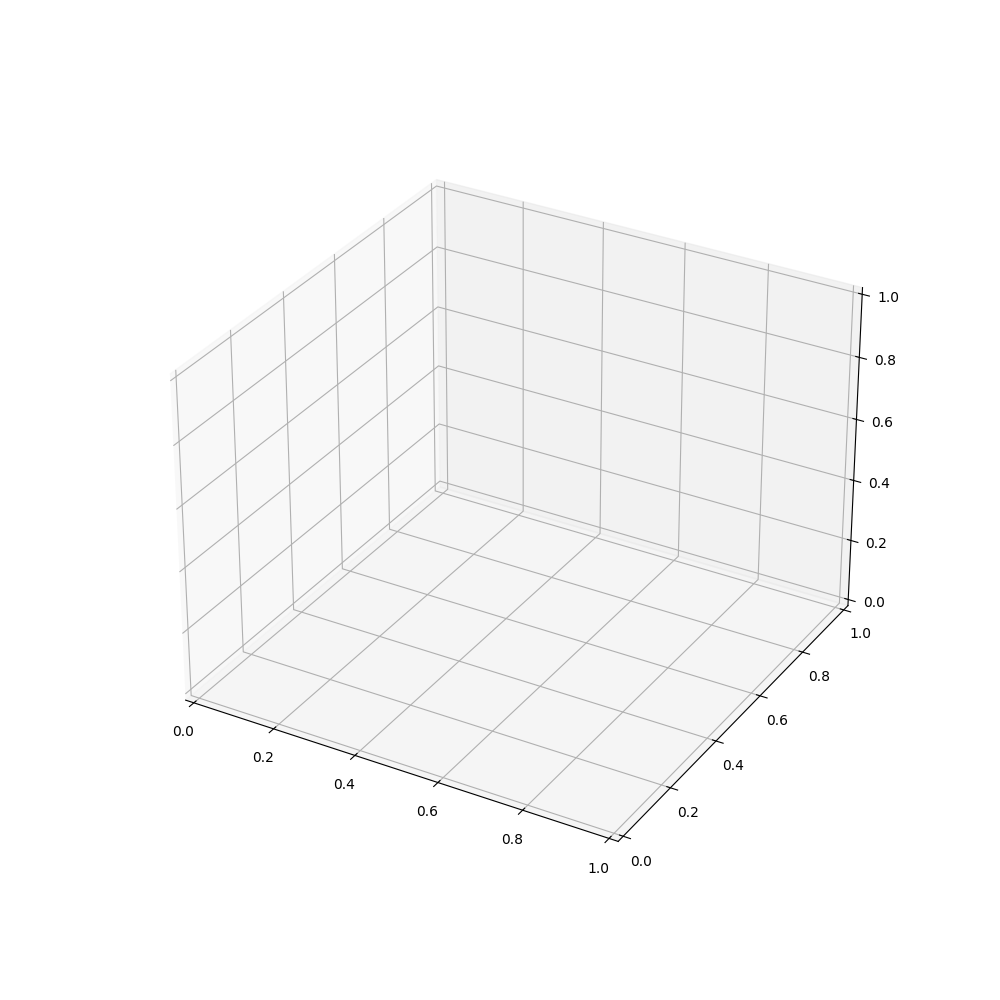

In [225]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming `pca_df` is a DataFrame with columns 'PC1', 'PC2', and 'PC3'
# And `pca` is a fitted PCA model with `explained_variance_ratio_`

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter using matplotlib
ax.scatter(
    pca_df['PC1'],  # X-axis
    pca_df['PC2'],  # Y-axis
    pca_df['PC3'],  # Z-axis
    c=pca_df['yy'].map(color_dict),       # Color of points
    s=50,           # Size of points
    alpha=0.7       # Transparency
)
for index, row in pca_df.iterrows():
    # print(row)
    # ax.text(9, 0, 0, "red", color='red')
    ax.text(row['PC1'], row['PC2'], row['PC3'], index)
# Set axis labels with explained variance ratios
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=14)
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)", fontsize=14)

# Optional: Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

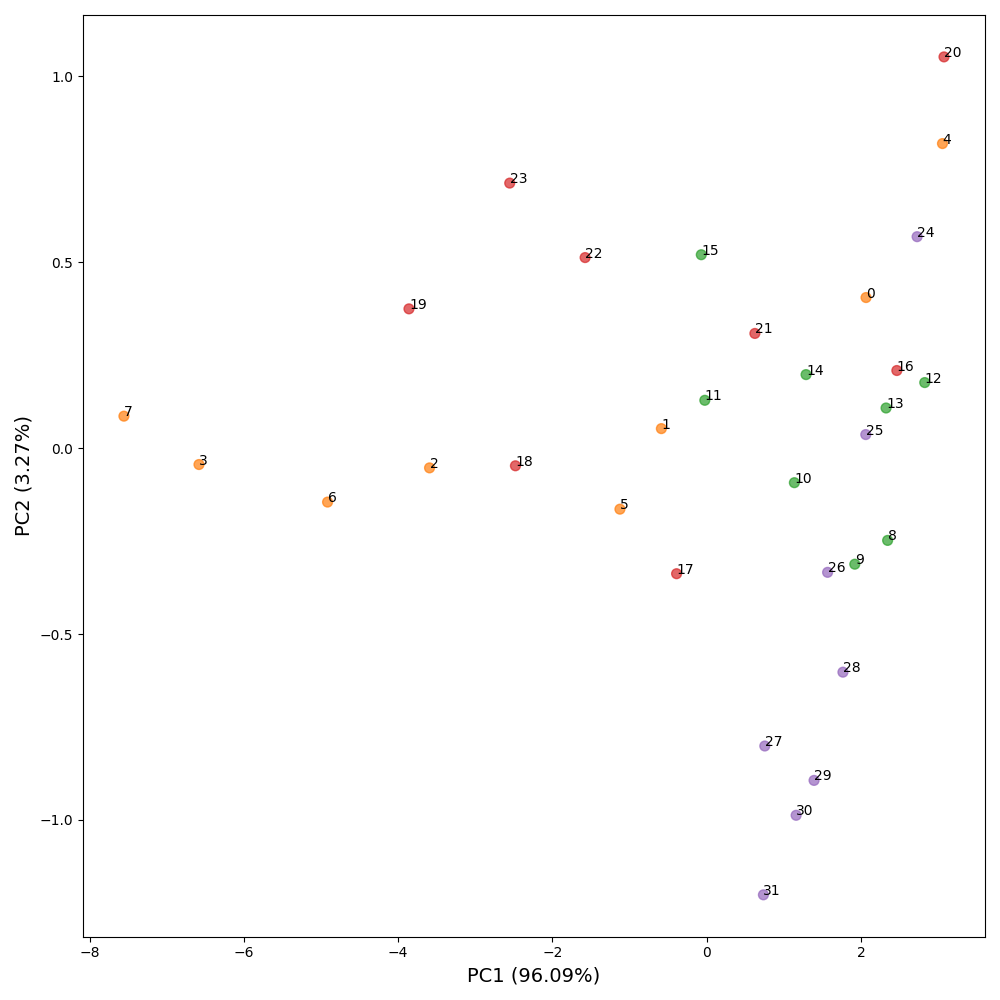

In [230]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming `pca_df` is a DataFrame with columns 'PC1', 'PC2', and 'PC3'
# And `pca` is a fitted PCA model with `explained_variance_ratio_`

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Plot the 3D scatter using matplotlib
ax.scatter(
    pca_df['PC1'],  # X-axis
    pca_df['PC2'],  # Y-axis
    c=pca_df['yy'].map(color_dict),       # Color of points
    s=50,           # Size of points
    alpha=0.7       # Transparency
)
for index, row in pca_df.iterrows():
    # print(row)
    # ax.text(9, 0, 0, "red", color='red')
    ax.text(row['PC1'], row['PC2'], index)
# Set axis labels with explained variance ratios
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=14)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=14)

# Optional: Adjust layout
fig.tight_layout()

# Show the plot
plt.show()